In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy import stats

# Introduction

In this project, we will be creating a model to predict the 

https://www.kaggle.com/birdy654/eeg-brainwave-dataset-feeling-emotions

# Data

## Reading in the dataset

In [2]:
df = pd.read_csv('emotions.csv')
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


Source: https://www.researchgate.net/publication/329403546_Mental_Emotional_Sentiment_Classification_with_an_EEG-based_Brain-machine_Interface

https://www.researchgate.net/publication/335173767_A_Deep_Evolutionary_Approach_to_Bioinspired_Classifier_Optimisation_for_Brain-Machine_Interaction

We must first filter the dataset to fit our model. As we can see, there are 2549 columns that get measured in this dataset. However, the model we chose only tests the "mean" columns. Although the descriptions of the columns are not very clear because there is no metadata for it, we tried to email the creator of the dataset but we were unable to get a response back. Other people have also posted about this problem, but there appears to be no public reply. We note that the features we are using are the first 5 column and the label we are predicting is the last column. We will only select the columns accordingly so that the table is filtered to only the columns we need.

In [3]:
df = df.iloc[:, list(range(5)) + [-1]] # selects first 5 columns and last
df

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,label
0,4.620,30.3,-356.0,15.60,26.3,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,NEUTRAL
...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,NEUTRAL
2128,16.300,31.3,-284.0,14.30,23.9,POSITIVE
2129,-0.547,28.3,-259.0,15.80,26.7,NEGATIVE
2130,16.800,19.9,-288.0,8.34,26.0,NEGATIVE


Using this line of code, we now have a dataframe that consists of the columns we need.

## Data Preprocessing

We start by making sure the data is in an understandable format. First, we have to check if there are any missing values. This line below first checks if anything is null and returns true or false accordingly, then takes the sum of all true and false (true being 1, false being 0), and then checks if there exist any Trues.

In [4]:
df.isnull().sum().any()

False

This proves that there exists no missing values. This is a very good thing for us because this means that we do not have to compensate for any missing data. Next, the 'label' column is what we will be trying to predict. Let's get the unique values and see how the distribution is for all of the unique values.

In [5]:
labels = df['label']
unique_labels = np.unique(labels)
unique_labels

array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object)

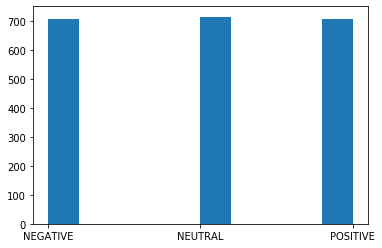

In [6]:
plt.hist(labels)
plt.show()

In [7]:
labels.value_counts()

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

We can see that the labels we are trying to predict will be 'neutral', 'positive', or 'negative'. We also know that they are about equally distributed. For a logistic regression model, we will need to assign the strings into a corresponding value. In this case, negative will be 0, neutral will be 1, and positive will be 2.

In [8]:
new_labels = {key: val for val, key in enumerate(unique_labels)}
new_labels

{'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

With this new mapping, we can now create a new column to map these values.

In [9]:
df['new_label'] = df['label'].map(new_labels)
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,label,new_label
0,4.62,30.3,-356.0,15.6,26.3,NEGATIVE,0
1,28.80,33.1,32.0,25.8,22.8,NEUTRAL,1
2,8.90,29.4,-416.0,16.7,23.7,POSITIVE,2
3,14.90,31.6,-143.0,19.8,24.3,POSITIVE,2
4,28.30,31.3,45.2,27.3,24.5,NEUTRAL,1


The 'new_label' column corresponds to the 'label' column. We will now create 2 training/testing set. The first training/testing split will be the first 80%/last 20% of the dataset. Because this dataset is sampled by time, the index may be dependent on each other. The next set will be a shuffled 80/20 split. We will perform a t-test at the end to see if there is a huge significance between the time taken for each sample. This training subset will be used to train our model, and our testing subset will be used to test the accuracy of our model. For our project, we will be using a 80/20 train test split, which is a very common machine learning split because it provides a substantial amount of training data, as well as a good amount of data to test on.

In [64]:
X = df.drop(['label', 'new_label'], axis = 1)
y = df['new_label']

# where the 80% of the dataset lies
index = int(len(df) * .8)

# obtaining the set, ns = no shuffle
X_ns_train, y_ns_train = X[:index], y[:index]
X_ns_test, y_ns_test = X[index:], y[:index]

In [65]:
X_ns_train.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a
0,4.62,30.3,-356.0,15.6,26.3
1,28.80,33.1,32.0,25.8,22.8
2,8.90,29.4,-416.0,16.7,23.7
3,14.90,31.6,-143.0,19.8,24.3
4,28.30,31.3,45.2,27.3,24.5


In [66]:
y_ns_train.head()

0    0
1    1
2    2
3    2
4    1
Name: new_label, dtype: int64

Now that we have a training/testing dataset, we can now proceed to train our model on the training the dataset.

# Creating the models

Because we are incorporating 5 different features, we will be cross-validating our models to make sure that we are not overfitting our model.

With 5 features, we will create 5 models:

$M1: \theta_0$ + $\theta_1$ * mean_0_a

$M2: \theta_0$ + $\theta_1$ * mean_0_a + $\theta_2$ * mean_1_a

$M3: \theta_0$ + $\theta_1$ * mean_0_a + $\theta_2$ * mean_1_a + $\theta_3$ * mean_2_a

$M4: \theta_0$ + $\theta_1$ * mean_0_a + $\theta_2$ * mean_1_a + $\theta_3$ * mean_2_a + $\theta_4$ * mean_3_a

$M5: \theta_0$ + $\theta_1$ * mean_0_a + $\theta_2$ * mean_1_a + $\theta_3$ * mean_2_a + $\theta_4$ * mean_3_a + $\theta_5$ * mean_4_a

Our process will be the same for each model: 
1. Create our feature vector by creating a column of ones
2. Convert the features into a list
3. Appending them to create a training vector
4. Train the model on it
5. Get the accuracy of each model on the training set

In [17]:
# creates a training vector, does step 1-3 from above
def training_vector(features, data):
    # creating a column of ones
    ones = np.ones(len(data))
    feat = [] # used to hold all the features after converting to a list
    
    # converts series into a list and stores it into a list
    for i in features:
        x_feat = data[i].tolist()
        feat.append(x_feat)
    
    X = np.vstack([ones, feat])
    X = X.T
    
    return X

Now, we will create the 5 models above and obtain the accuracy to see which model is performing the best.

### Model 1

In [34]:
# MODEL 1
X1 = training_vector(['# mean_0_a'], X_ns_train)
X1

array([[ 1.  ,  4.62],
       [ 1.  , 28.8 ],
       [ 1.  ,  8.9 ],
       ...,
       [ 1.  , 27.7 ],
       [ 1.  , 12.1 ],
       [ 1.  , 16.5 ]])

In [35]:
m1 = svm.SVC(kernel = 'linear', C = 1.0)
m1.fit(X1, y_ns_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [36]:
m1_pred = m1.predict(X1)
m1_pred

array([2, 1, 0, ..., 1, 0, 0])

In [37]:
# testing accuracy on m1
m1_acc = sum(m1_pred == y_ns_train) / len(y_ns_train)
m1_acc

0.6850439882697947

### Model 2

In [38]:
# MODEL 2
X2 = one_hot_encoding(['# mean_0_a', 'mean_1_a'], X_ns_train)
X2

array([[ 1.  ,  4.62, 30.3 ],
       [ 1.  , 28.8 , 33.1 ],
       [ 1.  ,  8.9 , 29.4 ],
       ...,
       [ 1.  , 27.7 , 32.6 ],
       [ 1.  , 12.1 , 30.6 ],
       [ 1.  , 16.5 , 31.6 ]])

In [39]:
m2 = svm.SVC(kernel = 'linear', C = 1.0)
m2.fit(X2, y_ns_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [40]:
m2_pred = m2.predict(X2)
m2

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [42]:
# testing accuracy on m2
m2_acc = sum(m2_pred == y_ns_train) / len(y_ns_train)
m2_acc

0.6821114369501466

### Model 3

In [43]:
# MODEL 3
X3 = one_hot_encoding(['# mean_0_a', 'mean_1_a', 'mean_2_a'], X_ns_train)
X3

array([[   1.  ,    4.62,   30.3 , -356.  ],
       [   1.  ,   28.8 ,   33.1 ,   32.  ],
       [   1.  ,    8.9 ,   29.4 , -416.  ],
       ...,
       [   1.  ,   27.7 ,   32.6 ,   31.2 ],
       [   1.  ,   12.1 ,   30.6 , -227.  ],
       [   1.  ,   16.5 ,   31.6 , -147.  ]])

In [44]:
m3 = svm.SVC(kernel = 'linear', C = 1.0)
m3.fit(X3, y_ns_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [45]:
m3_pred = m3.predict(X3)
m3_pred

array([0, 1, 0, ..., 1, 0, 0])

In [46]:
# testing accuracy on m3
m3_acc = sum(m3_pred == y_ns_train) / len(y_ns_train)
m3_acc

0.9043988269794722

### Model 4

In [47]:
# MODEL 4
X4 = one_hot_encoding(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a'], X_ns_train)
X4

array([[   1.  ,    4.62,   30.3 , -356.  ,   15.6 ],
       [   1.  ,   28.8 ,   33.1 ,   32.  ,   25.8 ],
       [   1.  ,    8.9 ,   29.4 , -416.  ,   16.7 ],
       ...,
       [   1.  ,   27.7 ,   32.6 ,   31.2 ,   25.2 ],
       [   1.  ,   12.1 ,   30.6 , -227.  ,   10.5 ],
       [   1.  ,   16.5 ,   31.6 , -147.  ,   20.  ]])

In [48]:
m4 = svm.SVC(kernel = 'linear', C = 1.0)
m4.fit(X4, y_ns_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [50]:
m4_pred = m4.predict(X4)
m4_pred

array([0, 1, 0, ..., 1, 0, 0])

In [51]:
# testing accuracy on m4
m4_acc = sum(m4_pred == y_ns_train) / len(y_ns_train)
m4_acc

0.9008797653958944

### Model 5

In [52]:
# MODEL 5
X5 = one_hot_encoding(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a'], X_ns_train)
X5

array([[   1.  ,    4.62,   30.3 , -356.  ,   15.6 ,   26.3 ],
       [   1.  ,   28.8 ,   33.1 ,   32.  ,   25.8 ,   22.8 ],
       [   1.  ,    8.9 ,   29.4 , -416.  ,   16.7 ,   23.7 ],
       ...,
       [   1.  ,   27.7 ,   32.6 ,   31.2 ,   25.2 ,   24.1 ],
       [   1.  ,   12.1 ,   30.6 , -227.  ,   10.5 ,   25.7 ],
       [   1.  ,   16.5 ,   31.6 , -147.  ,   20.  ,   25.5 ]])

In [53]:
m5 = svm.SVC(kernel = 'linear', C = 1.0)
m5.fit(X5, y_ns_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [54]:
m5_pred = m5.predict(X5)
m5_pred

array([0, 1, 0, ..., 1, 0, 0])

In [55]:
# testing accuracy on m5
m5_acc = sum(m5_pred == y_ns_train) / len(y_ns_train)
m5_acc

0.9020527859237537

### Model Summary

In [58]:
# comparing all model accuracys
model_acc = [m1_acc, m2_acc, m3_acc, m4_acc, m5_acc]
best_model_acc = model_acc.index(max(model_acc)) + 1 # index starts at 0 so we add 1 to get the correct model
print('The best model was model ', best_model_acc, ' with accuracy ', model_acc[best_model_acc])

The best model was model  3  with accuracy  0.9008797653958944


It appears that model 3 performs the best on the training dataset with no shuffle. We would think that the model that uses the most features gives us a more accurate prediction, but it seems like using more features would overfit the model. Based on our training model accuracy, we will proceed this project using model #3.

## Significance in time

In order to test whether there is a significance in time, we will perform a t-test. To do this, we will do 100 runs of:

1. Shuffle the dataset into a 80/20 split
2. Using model #3, we obtain the accuracy of the prediction
3. We store the prediction in a variable
4. We then use a t-test to see if there is a statistical difference between the time taken for each sample by comparing it to $\alpha = .05$

In [68]:
itterations = 100
predictions = []

for _ in range(itterations):
    # creating the shuffled split
    X_shuffled_train, _, y_shuffled_train, _ = train_test_split(X, y, train_size = .8)
    X1 = one_hot_encoding(['# mean_0_a', 'mean_1_a', 'mean_2_a'], X_shuffled_train)
    pred = m3.predict(X1)
    acc = sum(pred == y_shuffled_train) / len(y_shuffled_train)
    predictions.append(acc)

m3_acc would never change because the set is the same, so we can just reproduce this value 100 times to match the numbers of itterations.

In [81]:
# m3_acc would never change because the set is same, so we can just 
no_shuffle_value = [m3_acc] * itterations

In [82]:
stats.ttest_ind(predictions, no_shuffle_value)

Ttest_indResult(statistic=2.1259502633951324, pvalue=0.03474623100054999)

The p-value is lower than $\alpha = .05$ so we believe that there is no statistical difference between the time taken for each sample.